In [24]:
import pandas as pd
from csvkit import *
import matplotlib.pyplot as plt
import sqlite3
import networkx as nx
import numpy as np

In [8]:
!csvsql --db sqlite:///gene_disease.db --insert disgenet.csv go_human.tsv

E:\Program\Python309\lib\site-packages\agatesql\table.py:183: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
E:\Program\Python309\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
E:\Program\Python309\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=5>
E:\Program\Python309\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>


In [12]:
conn = sqlite3.connect('gene_disease.db')

# Question 1

In [13]:
query1 = """
SELECT last_year, COUNT(*) as associations, SUM(num_pubs) as publications
FROM disgenet
WHERE last_year >= 1960
GROUP BY last_year
"""
df1 = pd.read_sql_query(query1, conn)
df1['cumulative_associations'] = df1['associations'].cumsum()
df1['cumulative_publications'] = df1['publications'].cumsum()

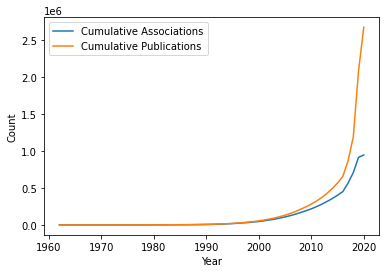

In [14]:
plt.plot(df1['last_year'], df1['cumulative_associations'], label='Cumulative Associations')
plt.plot(df1['last_year'], df1['cumulative_publications'], label='Cumulative Publications')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

The completion of the Human Genome Project in 2003 marked the beginning of the "Post-Genomic Era", which led to a rapid acceleration in gene-disease association research. Prior to this milestone, research was limited by the lack of comprehensive genetic data available to scientists. The Human Genome Project aimed to sequence and map all the genes of the human genome, providing researchers with an invaluable resource to better understand genetic factors in diseases.

In the years following 2003, the graph clearly shows an exponential increase in both associations and publications. This can be attributed to the greater availability of genetic data and the development of more advanced tools and techniques for analyzing gene-disease relationships. The Post-Genomic Era has allowed scientists to examine complex interactions between genes, environmental factors, and lifestyle, leading to a deeper understanding of disease etiology and the potential for personalized medicine.

Additionally, the increased rate of associations and publications indicates a growing interest and investment in the field, with interdisciplinary collaborations driving progress in biomedical research. Advances made during this time have fundamentally transformed our understanding of gene-disease relationships and have laid the foundation for future discoveries in prevention, diagnosis, and treatment.

# Question 2

In [23]:
query2 = """
SELECT gene_symbol, gene_name, COUNT(*) as associations, sum(num_pubs) as total_publications
FROM disgenet
WHERE disease_type != 'group'
GROUP BY gene_symbol, gene_name
ORDER BY associations DESC
LIMIT 10
"""

df2 = pd.read_sql_query(query2, conn)
print(df2.to_string())

  gene_symbol                                                               gene_name  associations  total_publications
0         TNF                                                   tumor necrosis factor          2489             18030.0
1        TP53                                                       tumor protein p53          2290             32482.0
2         IL6                                                           interleukin 6          2140             12912.0
3       VEGFA                                    vascular endothelial growth factor A          1712             13881.0
4        IL1B                                                      interleukin 1 beta          1603              7972.0
5        IL10                                                          interleukin 10          1496              6852.0
6       TGFB1                                       transforming growth factor beta 1          1413              6971.0
7      PIK3CA  phosphatidylinositol-4,5-

# Question 3

In [25]:
query3 = """
SELECT gene_name, disease_name 
FROM disgenet
"""
df3 = pd.read_sql_query(query3, conn)

In [27]:
# Create a bipartite network (genes and diseases as separate sets of nodes)
G = nx.Graph()
G.add_nodes_from(df3["gene_name"], bipartite=0)
G.add_nodes_from(df3["disease_name"], bipartite=1)
edges = zip(df3["gene_name"], df3["disease_name"])
G.add_edges_from(edges)

In [28]:
# Calculate degree distribution for genes and diseases
gene_degrees = [d for n, d in G.degree() if G.nodes[n]["bipartite"] == 0]
disease_degrees = [d for n, d in G.degree() if G.nodes[n]["bipartite"] == 1]

# Using NumPy to calculate histograms and bin edges
gene_histogram, gene_bin_edges = np.histogram(gene_degrees, bins=np.logspace(np.log10(1), np.log10(max(gene_degrees)), 20))
disease_histogram, disease_bin_edges = np.histogram(disease_degrees, bins=np.logspace(np.log10(1), np.log10(max(disease_degrees)), 20))

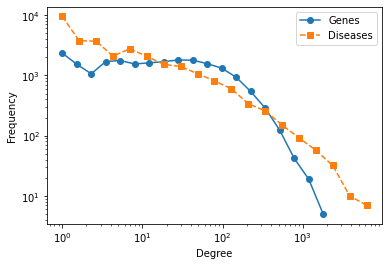

In [29]:
# Plot degree distributions
fig, ax = plt.subplots()
ax.loglog(gene_bin_edges[:-1], gene_histogram, marker='o', linestyle='-', label="Genes")
ax.loglog(disease_bin_edges[:-1], disease_histogram, marker='s', linestyle='--', label="Diseases")
ax.set_xlabel("Degree")
ax.set_ylabel("Frequency")
ax.legend()

plt.show()

# Question 4

In [49]:
query4 = """
SELECT gene_name, num_pubs, EI  
FROM disgenet
WHERE disease_name = "Alzheimer's Disease"
  AND EI >= 0.667
  AND num_pubs >= 11
GROUP BY gene_symbol
ORDER BY num_pubs DESC
LIMIT 10;
"""
df4 = pd.read_sql_query(query4, conn)
print(df4)

                                       gene_name  num_pubs      EI
0                               apolipoprotein E    3088.0  0.9461
1                 amyloid beta precursor protein    2615.0  0.9810
2             microtubule associated protein tau    1003.0  0.9900
3                                   presenilin 1     703.0  0.9707
4                               beta-secretase 1     490.0  0.9852
5  acetylcholinesterase (Cartwright blood group)     390.0  0.9845
6                          butyrylcholinesterase     348.0  0.9621
7                    colony stimulating factor 2     294.0  0.9660
8                        laminin subunit gamma 2     289.0  0.9654
9              brain derived neurotrophic factor     242.0  0.9582


# Question 5

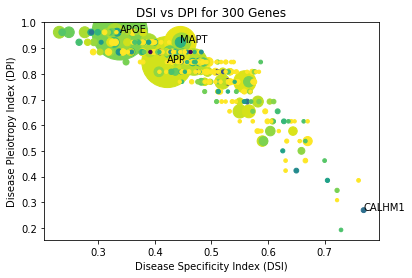

In [50]:
query5 = """
    SELECT *  
    FROM disgenet
    WHERE disease_name = "Alzheimer's Disease"
      AND EI >= 0.667
      AND num_pubs >= 11
    GROUP BY gene_symbol
    ORDER BY num_pubs DESC
    ;
"""
alz = pd.read_sql_query(query5, conn)
# Create the scatter plot
plt.scatter(alz.DSI, alz.DPI, c=alz.EI, s=alz.num_pubs, cmap='viridis')

# Label the specific genes
label_points = [
    ('APOE', 'APOE'),
    ('APP', 'APP'),
    ('MAPT', 'MAPT'),
    ('CALHM1', 'CALHM1')
]

for label, gene in label_points:
    gene_data = alz.loc[alz['gene_symbol'] == gene]
    plt.text(gene_data.DSI, gene_data.DPI, label)

# Add axis labels and a title
plt.xlabel('Disease Specificity Index (DSI)')
plt.ylabel('Disease Pleiotropy Index (DPI)')
plt.title("DSI vs DPI for 300 Genes")

# Show the plot
plt.show()

# Question 6

In [48]:
query6 = """
    SELECT GO.go_id, GO.qualifier, GO.go_term, COUNT(GO.gene_id) AS Number_of_Genes
    FROM disgenet as DG
    LEFT JOIN go_human as GO ON GO.gene_id = DG.gene_id  
    WHERE DG.disease_name = "Alzheimer's Disease" and GO.category = 'Process' 
      AND DG.EI >= 0.667
      AND DG.num_pubs >= 11 
    GROUP BY GO.go_id, GO.qualifier, GO.go_term
    ORDER BY Number_of_Genes DESC
    ;
    
"""
df6 = pd.read_sql_query(query6, conn)
df6

,go_id,qualifier,go_term,Number_of_Genes
0,GO:0010628,involved_in,positive regulation of gene expression,74
1,GO:0045944,involved_in,positive regulation of transcription by RNA po...,67
2,GO:0006468,involved_in,protein phosphorylation,55
3,GO:0007165,involved_in,signal transduction,55
4,GO:0043066,involved_in,negative regulation of apoptotic process,45
...,...,...,...,...
3841,GO:2001242,involved_in,regulation of intrinsic apoptotic signaling pa...,1
3842,GO:2001260,involved_in,regulation of semaphorin-plexin signaling pathway,1
3843,GO:2001268,involved_in,negative regulation of cysteine-type endopepti...,1
3844,GO:2001272,involved_in,positive regulation of cysteine-type endopepti...,1


# Question 7

In [53]:
query7 = """
    SELECT disgenet.disease_name, count(disgenet.gene_symbol) as linked_count FROM disgenet 
    INNER JOIN (SELECT gene_symbol FROM disgenet WHERE disease_name = "Alzheimer's Disease" AND EI >= 0.667 AND num_pubs >= 11 GROUP BY gene_symbol) 
    As alz on alz.gene_symbol = disgenet.gene_symbol
    WHERE disgenet.disease_name <> "Alzheimer's Disease" 
    GROUP BY disgenet.disease_name
    ORDER BY linked_count DESC
    LIMIT 10
    ;
"""
df7 = pd.read_sql_query(query7, conn)
df7

,disease_name,linked_count
0,Neoplasms,292
1,Malignant Neoplasms,285
2,Primary malignant neoplasm,280
3,Impaired cognition,278
4,Malignant neoplasm of breast,265
5,Breast Carcinoma,263
6,Tumor Cell Invasion,262
7,Neurodegenerative Disorders,261
8,Parkinson Disease,258
9,Neoplasm Metastasis,253


# Question 8

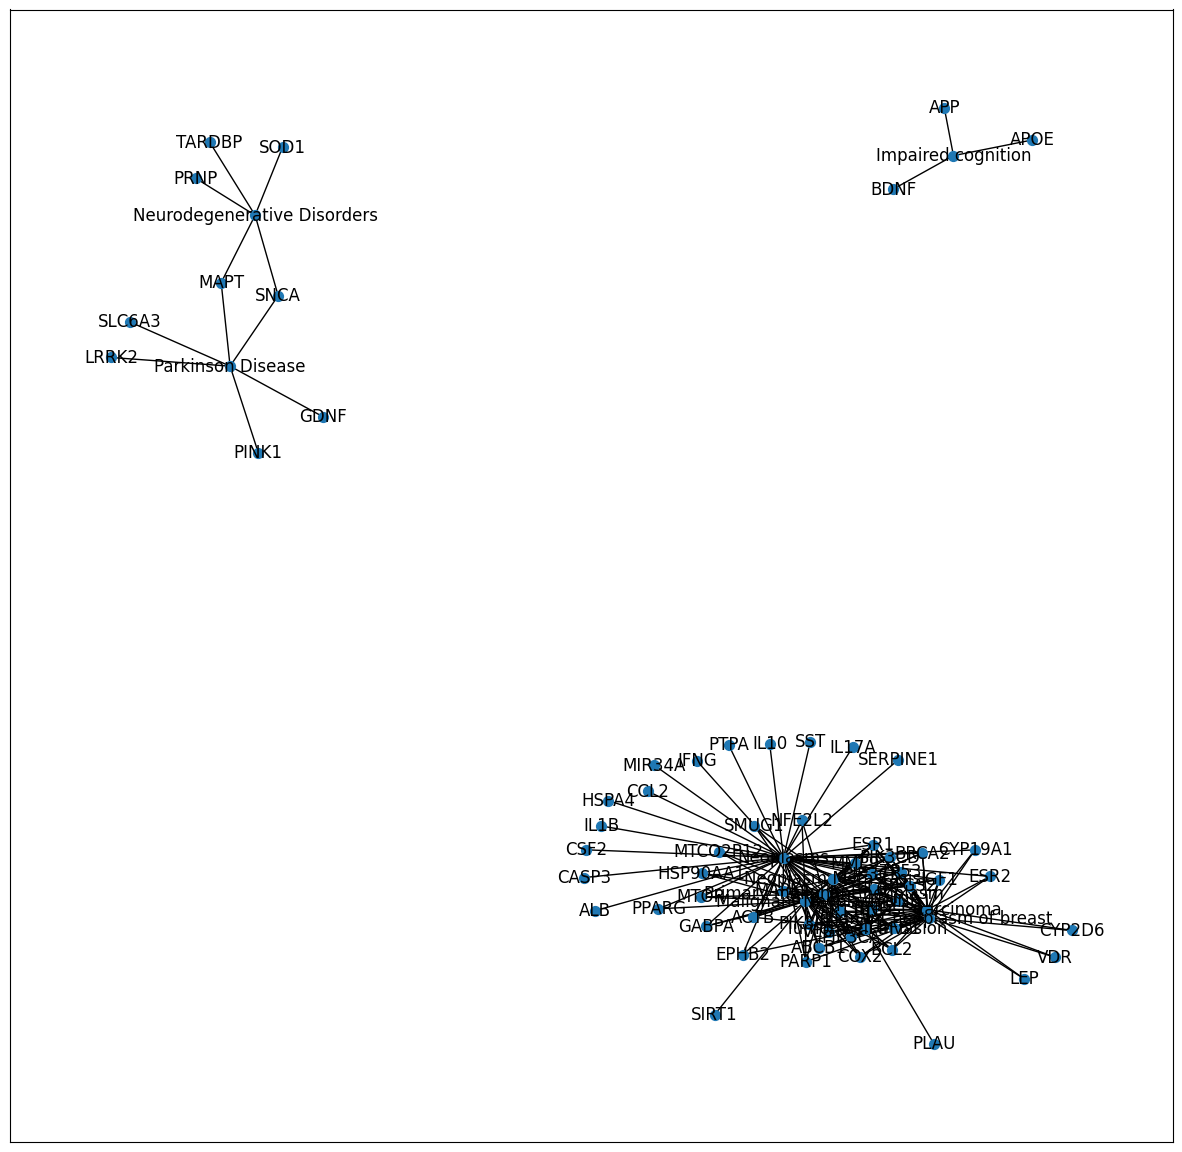

In [56]:
query8 = """
    SELECT disgenet.disease_name, disgenet.gene_symbol FROM disgenet INNER JOIN
    (SELECT disgenet.disease_name, count(disgenet.gene_symbol) as linked_count FROM disgenet 
    INNER JOIN (SELECT gene_symbol FROM disgenet WHERE disease_name = "Alzheimer's Disease" AND EI >= 0.667 AND num_pubs >= 11 GROUP BY gene_symbol) 
    As alz on alz.gene_symbol = disgenet.gene_symbol
    WHERE disgenet.disease_name <> "Alzheimer's Disease" 
    GROUP BY disgenet.disease_name
    ORDER BY linked_count DESC
    LIMIT 10) as q7 on q7.disease_name = disgenet.disease_name
    INNER JOIN (SELECT gene_symbol FROM disgenet WHERE disease_name = "Alzheimer's Disease" AND EI >= 0.667 AND num_pubs >= 11 GROUP BY gene_symbol) 
    As alz on alz.gene_symbol = disgenet.gene_symbol
    WHERE disgenet.disease_name <> "Alzheimer's Disease" 
    
    ORDER BY disgenet.num_pubs DESC
    LIMIT 200
    ;
"""

net = pd.read_sql_query(query8, conn)
plt.figure(figsize=(15,15), dpi=100)
G = nx.from_pandas_edgelist(net, 'gene_symbol', 'disease_name', create_using=nx.Graph())
nx.draw_networkx(G, with_labels=True, node_size=50)

In [57]:
conn.close()